# <font color = 'pickle'> Install Libraries/ Set Google Colab

In [1]:
from pathlib import Path
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab import drive
  drive.mount('/content/drive')
  !pip install --upgrade fastai timm kaggle -qq
  base_folder = Path('/content/drive/MyDrive/data')
  data_folder = Path('/content')
else:
  base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor/data')
  data_folder = Path('/home/harpreet/data')
  print('Not running on CoLab')

Running on CoLab
Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.7 MB/s eta 0:00:00


# <font color = 'pickle'> Specify Project Folder

In [2]:
kaggle_api = base_folder/'.kaggle'
data_folder = data_folder/'inclass_kaggle_data'
model_folder = base_folder/'models/dl_fall_2023/inclass_kaglle'
archive_folder  = data_folder/'archive'

In [3]:
data_folder.mkdir(exist_ok=True)
kaggle_api.mkdir(exist_ok=True)
model_folder.mkdir(exist_ok=True, parents=True)
archive_folder.mkdir(exist_ok=True)


In [4]:
import os
if 'google.colab' in str(get_ipython()):
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/data/.kaggle/"

In [5]:
if 'google.colab' in str(get_ipython()):
    !chmod 600 /content/drive/MyDrive/data/.kaggle/kaggle.json

In [6]:
if 'google.colab' in str(get_ipython()):
    ! ls -la  /content/drive/MyDrive/data/.kaggle/kaggle.json

-rw------- 1 root root 67 Nov 27 22:37 /content/drive/MyDrive/data/.kaggle/kaggle.json


# <font color = 'pickle'> Import Libraries

In [7]:
import fastai; fastai.__version__

'2.7.13'

In [8]:
from fastai.vision.all import *
from kaggle import api
from zipfile import ZipFile
import timm

# <font color = 'pickle'> Get Data from kaggle

In [9]:
! kaggle competitions download inclassplantpathologysmallf23 -p {archive_folder}


100% 552M/552M [00:14<00:00, 43.4MB/s]
100% 552M/552M [00:14<00:00, 38.6MB/s]


In [10]:
file = archive_folder/'inclassplantpathologysmallf23.zip'
with ZipFile(file , 'r') as f:
    filenames = f.namelist()

In [11]:
filenames[0:10]

['sample_submission.csv',
 'test/test/test_image_1.jpg',
 'test/test/test_image_10.jpg',
 'test/test/test_image_100.jpg',
 'test/test/test_image_1000.jpg',
 'test/test/test_image_1001.jpg',
 'test/test/test_image_1002.jpg',
 'test/test/test_image_1003.jpg',
 'test/test/test_image_1004.jpg',
 'test/test/test_image_1005.jpg']

In [12]:
with ZipFile(file ,'r') as f:
 f.extractall(path = data_folder)

# <font color = 'pickle'> Understand Data

In [13]:
train_path = data_folder/'train/train'

In [14]:
files = get_image_files(train_path)

##  <font color = 'pickle'>Look at a sample Image

(600, 400)


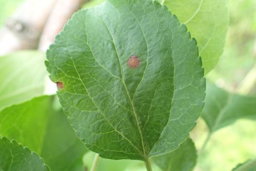

In [15]:
sample_image = PILImage.create(files[0])
print(sample_image.size)
sample_image.to_thumb(256)

##  <font color = 'pickle'> Check size of all the images

In [16]:
from fastcore.parallel import *

In [17]:
def get_sizes(image):
    return PILImage.create(image).size

In [18]:
sizes = parallel(get_sizes, files, progress=True)

In [19]:
pd.Series(sizes).value_counts()

(600, 400)    12409
(600, 450)      627
(600, 600)        3
(450, 600)        2
(600, 337)        1
dtype: int64

# <font color = 'pickle'> Data Loader

In [20]:
df = pd.read_csv(data_folder/'train.csv')

In [21]:
df.head()

,image,labels
0,train_image_1.jpg,powdery_mildew
1,train_image_2.jpg,scab
2,train_image_3.jpg,scab frog_eye_leaf_spot
3,train_image_4.jpg,powdery_mildew
4,train_image_5.jpg,complex


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13042 entries, 0 to 13041
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   13042 non-null  object
 1   labels  13042 non-null  object
dtypes: object(2)
memory usage: 203.9+ KB


In [23]:
df.iloc[0:10, ]

,image,labels
0,train_image_1.jpg,powdery_mildew
1,train_image_2.jpg,scab
2,train_image_3.jpg,scab frog_eye_leaf_spot
3,train_image_4.jpg,powdery_mildew
4,train_image_5.jpg,complex
5,train_image_6.jpg,rust
6,train_image_7.jpg,scab frog_eye_leaf_spot
7,train_image_8.jpg,scab frog_eye_leaf_spot
8,train_image_9.jpg,frog_eye_leaf_spot
9,train_image_10.jpg,frog_eye_leaf_spot


In [24]:
# def get_x(df): return str(small_train_images) + '/' + (df['image'])
def get_x(df):
  return data_folder/'train/train'/df['image']
def get_y(df):
  return df['labels'].split(' ')
dblock = DataBlock(get_x= get_x,
                   get_y = get_y,
                   splitter = RandomSplitter(seed = 42))
dsets = dblock.datasets(df)
dsets.train[15]

(Path('/content/inclass_kaggle_data/train/train/train_image_10535.jpg'),
 ['rust', 'complex'])

In [25]:
dblock = DataBlock(blocks= (ImageBlock, MultiCategoryBlock),
                   get_x= get_x,
                   get_y = get_y,
                  splitter = RandomSplitter(seed = 42))
dsets = dblock.datasets(df)
dsets.train[15]

(PILImage mode=RGB size=600x400, TensorMultiCategory([1., 0., 0., 0., 1., 0.]))

In [26]:
dsets.train.vocab

['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']

In [27]:
idxs = torch.where(dsets.train[15][1] == 1.)[0]

In [28]:
dsets.train.vocab[idxs]

(#2) ['complex','rust']

In [29]:
dblock = DataBlock(blocks= (ImageBlock, MultiCategoryBlock),
                  get_x= get_x,
                  get_y = get_y,
                  splitter = RandomSplitter(seed = 42),
                  item_tfms= Resize(400, method = 'squish'),
                  batch_tfms= aug_transforms(size = 128, min_scale = 0.75))
dsets = dblock.datasets(df)
dsets.train[3]

(PILImage mode=RGB size=600x400, TensorMultiCategory([0., 0., 0., 0., 0., 1.]))

In [30]:
import os
os.cpu_count()

8

In [31]:
dls = dblock.dataloaders(df, bs = 64, num_workers =8)

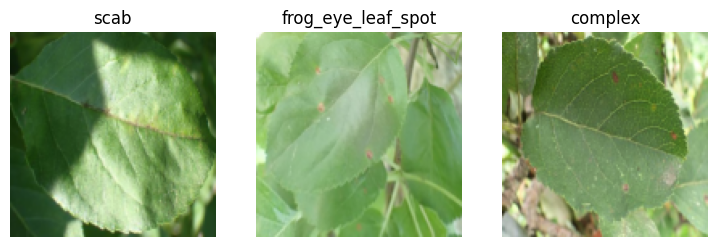

In [32]:
dls.train.show_batch(max_n=3)

In [33]:
dls.device

device(type='cuda', index=0)

# <font color = 'pickle'> Model

In [ ]:
f1score = F1ScoreMulti(thresh = 0.5)
loss_func = nn.BCEWithLogitsLoss()
learn = vision_learner(dls,'resnet26d', metrics = [F1ScoreMulti(thresh = 0.5)], path = model_folder).to_fp16()

SuggestedLRs(minimum=0.025118863582611083, steep=0.02754228748381138, valley=0.001737800776027143, slide=0.015848932787775993)

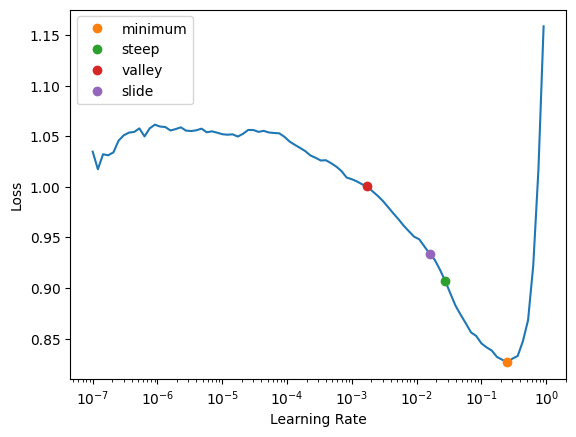

In [ ]:
learn.lr_find(suggest_funcs = (minimum, steep, valley, slide))

In [ ]:
learn.fine_tune(3, 0.03)

epoch,train_loss,valid_loss,f1_score,time
0,0.377239,0.284189,0.631706,00:24


epoch,train_loss,valid_loss,f1_score,time
0,0.206420,0.183851,0.791964,00:25
1,0.148369,0.134131,0.827366,00:24
2,0.107174,0.118625,0.852615,00:24


# <font color ='pickle'> Find the threshold

In [ ]:
F1ScoreMulti??

In [ ]:
learn.metrics = F1ScoreMulti(thresh = 0.1)

In [ ]:
learn.metrics

(#1) [<fastai.metrics.AccumMetric object at 0x7d4c0e838490>]

In [ ]:
learn.validate()

(#2) [0.11862465739250183,0.8099160494764351]

In [ ]:
learn.metrics = F1ScoreMulti(thresh = 0.9)

In [ ]:
learn.validate()

(#2) [0.11862465739250183,0.717659949802655]

In [ ]:
preds, targs = learn.get_preds()

In [ ]:
preds.shape, targs.shape

(torch.Size([2608, 6]), torch.Size([2608, 6]))

In [ ]:
f1score = F1ScoreMulti(thresh = None, sigmoid=False)

In [ ]:
idxs = (preds>0.5) * 1

In [ ]:
f1score(idxs, targs)

0.852615431202388

In [ ]:
xs = torch.linspace(0.05, 0.95, 29)

In [ ]:
f1scores = [f1score((preds>i) * 1, targs) for i in xs]

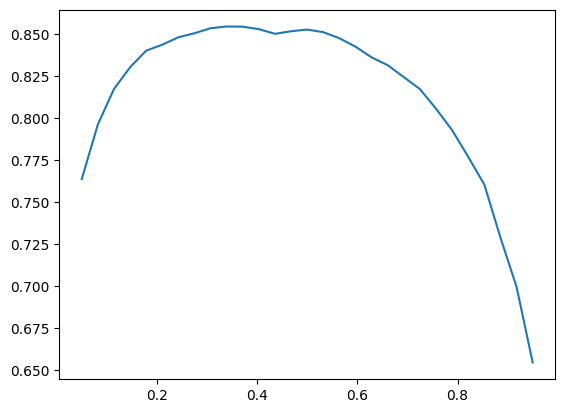

In [ ]:
plt.plot(xs, f1scores)

In [ ]:
torch.argmax(torch.tensor(f1scores))

tensor(9)

In [ ]:
xs[9]

tensor(0.3393)

In [ ]:
f1scores[9]

0.8544487820571924

# <font color ='pickle'>Test Predictions

In [ ]:
test_files = get_image_files(data_folder/'test/test').sorted()

In [ ]:
test_files

(#5590) [Path('/content/inclass_kaggle_data/test/test/test_image_1.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_10.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_100.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_1000.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_1001.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_1002.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_1003.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_1004.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_1005.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_1006.jpg')...]

In [ ]:
test_dl = learn.dls.test_dl(test_files)

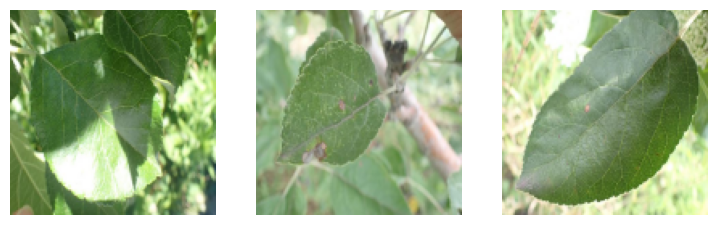

In [ ]:
test_dl.show_batch(max_n=3)

In [ ]:
preds, _ = learn.tta(dl = test_dl)

In [ ]:
preds

tensor([[8.0797e-04, 8.9803e-04, 9.6855e-01, 2.7000e-03, 9.7359e-05, 2.6052e-02],
        [7.9695e-01, 4.2143e-01, 7.1474e-04, 1.0320e-02, 3.7826e-03, 1.9763e-01],
        [1.7792e-01, 8.4083e-01, 5.3235e-04, 1.3504e-01, 5.1045e-03, 2.3739e-02],
        ...,
        [4.0294e-04, 1.9331e-04, 9.9972e-01, 2.5354e-04, 1.8511e-04, 2.4831e-04],
        [3.3764e-01, 8.0718e-01, 8.5627e-04, 1.5611e-03, 3.5864e-03, 1.6357e-01],
        [8.7174e-03, 4.1063e-03, 4.0483e-03, 8.7713e-01, 2.0048e-04, 8.2385e-02]])

In [ ]:
pred_decoded = [torch.where(pred>0.34)[0] for pred in preds]

In [ ]:
pred_decoded[0:20]

[tensor([2]),
 tensor([0, 1]),
 tensor([1]),
 tensor([2]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([0, 5]),
 tensor([5]),
 tensor([2]),
 tensor([5]),
 tensor([2]),
 tensor([1]),
 tensor([5]),
 tensor([5]),
 tensor([0, 4]),
 tensor([2]),
 tensor([2, 5]),
 tensor([5])]

In [ ]:
vocab = learn.dls.vocab

In [ ]:
pred_labels = [vocab[pred] for pred in pred_decoded[0:20]]

In [ ]:
pred_labels

[(#1) ['healthy'],
 (#2) ['complex','frog_eye_leaf_spot'],
 (#1) ['frog_eye_leaf_spot'],
 (#1) ['healthy'],
 (#1) ['frog_eye_leaf_spot'],
 (#1) ['frog_eye_leaf_spot'],
 (#1) ['frog_eye_leaf_spot'],
 (#1) ['complex'],
 (#2) ['complex','scab'],
 (#1) ['scab'],
 (#1) ['healthy'],
 (#1) ['scab'],
 (#1) ['healthy'],
 (#1) ['frog_eye_leaf_spot'],
 (#1) ['scab'],
 (#1) ['scab'],
 (#2) ['complex','rust'],
 (#1) ['healthy'],
 (#2) ['healthy','scab'],
 (#1) ['scab']]

In [ ]:
[" ".join(pred)for pred in pred_labels]

['healthy',
 'complex frog_eye_leaf_spot',
 'frog_eye_leaf_spot',
 'healthy',
 'frog_eye_leaf_spot',
 'frog_eye_leaf_spot',
 'frog_eye_leaf_spot',
 'complex',
 'complex scab',
 'scab',
 'healthy',
 'scab',
 'healthy',
 'frog_eye_leaf_spot',
 'scab',
 'scab',
 'complex rust',
 'healthy',
 'healthy scab',
 'scab']

In [ ]:
pred_labels = [' '.join(vocab[torch.where(pred>0.34)[0]]) for pred in preds]

In [ ]:
pred_labels[0:20]

['healthy',
 'complex frog_eye_leaf_spot',
 'frog_eye_leaf_spot',
 'healthy',
 'frog_eye_leaf_spot',
 'frog_eye_leaf_spot',
 'frog_eye_leaf_spot',
 'complex',
 'complex scab',
 'scab',
 'healthy',
 'scab',
 'healthy',
 'frog_eye_leaf_spot',
 'scab',
 'scab',
 'complex rust',
 'healthy',
 'healthy scab',
 'scab']

# <font color = 'pickle'> Ensemble Model

In [34]:
from fastcore.parallel import *

In [35]:
loss_func = nn.BCEWithLogitsLoss()
test_files = get_image_files(data_folder/'test/test').sorted()

In [42]:
def train(arch, size, item=Resize(480, method='squish'), accum=1, finetune=True, epochs=12, train_path = data_folder/'train_images'):
    dblock = DataBlock(blocks= (ImageBlock, MultiCategoryBlock),
                   get_x= get_x,
                   get_y = get_y,
                   splitter = RandomSplitter(seed = 42, valid_pct = 0.2),
                   item_tfms= item,
                   batch_tfms= aug_transforms(size=size, min_scale = 0.75))

    dls = dblock.dataloaders(df, bs = 32, num_workers =8)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, metrics=[F1ScoreMulti(thresh = 0.39)], cbs=cbs, path = model_folder).to_fp16()
    if finetune:
        learn.fine_tune(epochs, 0.03)
        test_dl = learn.dls.test_dl(test_files)
        return learn.tta(dl = test_dl)
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01)

In [43]:
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [44]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

In [45]:
res = 640,480
models = {
    'convnext_large_in22k': {
        (Resize(res), (320,224)),
    }, 'vit_large_patch16_224': {
        (Resize(480, method='squish'), 224),
        (Resize(res), 224),
    }
}

In [46]:
if 'google.colab' in str(get_ipython()):
  !pip install --upgrade fastai fastcore timm==0.6.13 kaggle pynvml nbdev -qq

In [47]:
tta_res = []
for arch,details in models.items():
    for item,size in details:
        print('---',arch)
        print(size)
        print(item.name)
        tta_res.append(train(arch, size, item=item, accum=2, train_path=train_path))
        gc.collect()
        torch.cuda.empty_cache()

--- convnext_large_in22k
(320, 224)
Resize -- {'size': (480, 640), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_large_in22k to current convnext_large.fb_in22k.


model.safetensors:   0%|          | 0.00/919M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,f1_score,time
0,0.222069,0.157236,0.753700,01:23


epoch,train_loss,valid_loss,f1_score,time
0,0.141941,0.102472,0.867134,01:48
1,0.122978,0.094206,0.890900,01:48
2,0.123764,0.098629,0.889360,01:48
3,0.115800,0.085905,0.900536,01:49
4,0.110967,0.094300,0.895037,01:49
5,0.096926,0.086573,0.901744,01:49
6,0.077785,0.082647,0.899800,01:48
7,0.059994,0.088039,0.901984,01:48
8,0.046411,0.088079,0.908571,01:49
9,0.035420,0.093609,0.915820,01:49


--- vit_large_patch16_224
224
Resize -- {'size': (480, 640), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

epoch,train_loss,valid_loss,f1_score,time
0,0.210054,0.124887,0.858826,01:22


epoch,train_loss,valid_loss,f1_score,time
0,0.137291,0.101842,0.884785,01:46
1,0.155032,0.157461,0.827616,01:46
2,0.153719,0.175835,0.760560,01:45
3,0.149000,0.128627,0.857820,01:45
4,0.132496,0.118058,0.869277,01:45
5,0.130820,0.104809,0.869034,01:45
6,0.114501,0.109513,0.869884,01:45
7,0.097005,0.090815,0.898184,01:45
8,0.077686,0.093917,0.899715,01:45
9,0.063032,0.096630,0.904867,01:45


--- vit_large_patch16_224
224
Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


epoch,train_loss,valid_loss,f1_score,time
0,0.183849,0.155288,0.816926,01:21


epoch,train_loss,valid_loss,f1_score,time
0,0.118098,0.105427,0.880950,01:44
1,0.121714,0.282374,0.773854,01:44
2,0.124734,0.128540,0.849334,01:44
3,0.122419,0.134191,0.855522,01:43
4,0.114564,0.153631,0.820868,01:44
5,0.096319,0.108075,0.887658,01:44
6,0.084537,0.105287,0.874188,01:44
7,0.071338,0.100667,0.886096,01:44
8,0.047902,0.103579,0.902521,01:44
9,0.032791,0.101542,0.907480,01:44


# <font color ='pickle'> Kaggle Submission

In [48]:
save_pickle('tta_res.pkl', tta_res)

In [49]:
doc(first)

In [50]:
tta_prs = first(zip(*tta_res))

In [51]:
tta_prs += tta_prs[1:3]

In [52]:
avg_pr = torch.stack(tta_prs).mean(0)
avg_pr.shape

torch.Size([5590, 6])

In [53]:
idxs = avg_pr.argmax(dim=1)

In [62]:
dblock = DataBlock(blocks= (ImageBlock, MultiCategoryBlock),
                   get_x= get_x,
                   get_y = get_y,
                   splitter = RandomSplitter(seed = 42, valid_pct = 0.2),
                   item_tfms= item,
                   batch_tfms= aug_transforms(size=size, min_scale = 0.75))

dls = dblock.dataloaders(df, bs = 64)

In [63]:
vocab = np.array(dls.vocab)

In [64]:
vocab

array(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew',
       'rust', 'scab'], dtype='<U18')

In [85]:
ss = pd.read_csv(data_folder/'sample_submission.csv')
ss = ss.sort_values(by = 'image')
ss['labels'] = vocab[idxs]
ss.to_csv(model_folder/'final_sub.csv', index = False)
! head {model_folder/'final_sub.csv'}

image,labels
test_image_1.jpg,healthy
test_image_10.jpg,complex
test_image_100.jpg,frog_eye_leaf_spot
test_image_1000.jpg,frog_eye_leaf_spot
test_image_1001.jpg,rust
test_image_1002.jpg,frog_eye_leaf_spot
test_image_1003.jpg,frog_eye_leaf_spot
test_image_1004.jpg,complex
test_image_1005.jpg,complex


In [86]:
comp = 'inclassplantpathologysmallf23'

In [87]:
api.competition_submit(model_folder/'final_sub.csv', 'inclass nov14', comp)

100%|██████████| 161k/161k [00:01<00:00, 144kB/s]


Successfully submitted to Inclass_Plant_Pathology_Small_F23